## LightGBM

In [51]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [5]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [6]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)
tf_idf = vectorizer.fit_transform(X.release)

Подберем параметры с помощью optuna, но смотреть будем только на точность, так как вычисление calc_metrics занимает очень много времени

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, random_state=42, test_size=0.2)


def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
    }
    model = LGBMClassifier(
        num_leaves=params["num_leaves"],
        n_estimators=params["n_estimators"],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        min_data_in_leaf=params['min_data_in_leaf'],
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        verbosity=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
study.best_params

{'max_depth': 14,
 'min_data_in_leaf': 3,
 'n_estimators': 414,
 'learning_rate': 0.021200158544318115}

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.50      0.58      0.54        26
         1.0       0.67      0.53      0.59        19

    accuracy                           0.59        68
   macro avg       0.61      0.59      0.59        68
weighted avg       0.60      0.59      0.59        68



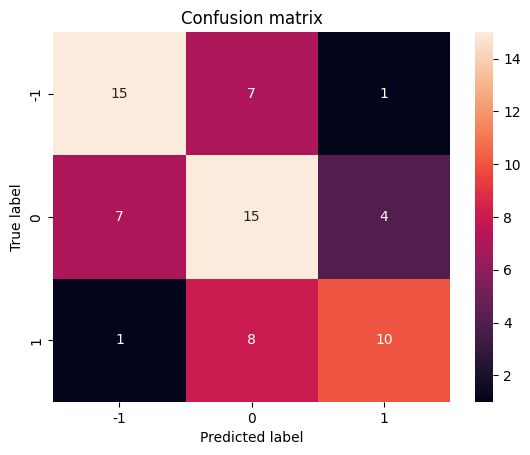

In [45]:
model = LGBMClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    verbosity=-1
    )
metrics, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF LigthGBM"
)

In [46]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF LigthGBM,0.588235,0.592041,0.585138,0.60628,0.733379,0.738573


Попробуем еще подобрать параметры для неглубоких деревьев, до 5, но увеличив их количество.

In [61]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, random_state=42, test_size=0.2)


def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
    }
    model = LGBMClassifier(
        num_leaves=params["num_leaves"],
        n_estimators=params["n_estimators"],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        min_data_in_leaf=params['min_data_in_leaf'],
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        verbosity=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
study.best_params

{'max_depth': 5,
 'num_leaves': 11,
 'min_data_in_leaf': 17,
 'n_estimators': 6143,
 'learning_rate': 0.4971212141413742}

              precision    recall  f1-score   support

        -1.0       0.71      0.52      0.60        23
         0.0       0.47      0.65      0.55        26
         1.0       0.73      0.58      0.65        19

    accuracy                           0.59        68
   macro avg       0.64      0.58      0.60        68
weighted avg       0.62      0.59      0.59        68



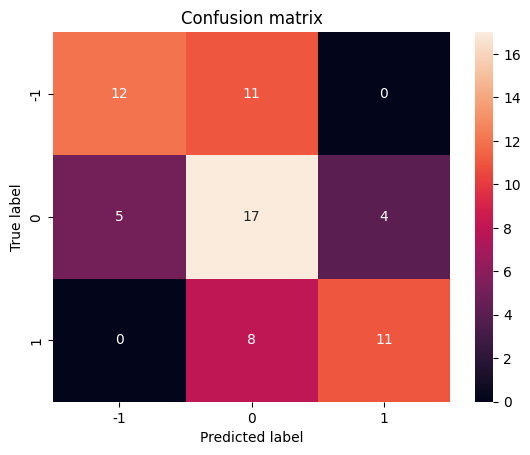

In [63]:
model = LGBMClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    verbosity=-1
    )
metrics, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF LigthGBM"
)

In [64]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF LigthGBM,0.588235,0.598482,0.584844,0.637146,0.789938,0.796427


В итоге, попробовав три разных бустинга (XGboost, CatBoost, LightGBM), не удалось приблизится к лучшей линейной модели.